In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from keras.layers import LSTM, Dropout
from rbf_layer import RBFLayer, InitCentersRandom
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

In [20]:
COMPANY = 'peo'

In [21]:
def roll_beta(window_size, stock, market):
    data = {'X': market, 'Y': stock}
    df = pd.DataFrame(data)
    cov = df.X.rolling(window=window_size).cov(df.Y)
    var = df.X.rolling(window=window_size).var()
    roling_beta = cov/var
    return np.array(roling_beta[window_size - 1:])

In [22]:
def return_from_stock(stock_data):
    stock = pd.read_csv(f"{stock_data}")
    #creating new column 'return' it is percentage change between current and last month close price
    stock['return'] = stock.Zamkniecie.pct_change()
    return np.array(stock['return'][1:]) # first value is NaN so [1:]

In [23]:
wig_20_return = return_from_stock('wig20_m.csv')
peo_return = return_from_stock('peo_m.csv')

In [24]:
peo_roll_beta = roll_beta(36, peo_return, wig_20_return)

In [25]:
peo_roll_beta

array([0.9772635 , 0.97014216, 1.00021326, 1.00341387, 0.99066662,
       1.00436244, 0.99490991, 1.02171093, 1.03098369, 1.03367474,
       1.051477  , 1.0441973 , 1.06097197, 1.06000448, 1.03501676,
       1.04392938, 1.05036511, 1.06179624, 1.04459305, 1.05446398,
       1.04846115, 1.0680065 , 1.07123908, 1.07525705, 1.06774364,
       1.08922898, 1.13356561, 1.12231121, 1.11750739, 1.11221958,
       1.11222089, 1.15435166, 1.18812062, 1.26028061, 1.23078474,
       1.43892495, 1.44945814, 1.44257389, 1.49245589, 1.48736234,
       1.48676661, 1.49808716, 1.51245944, 1.49931122, 1.49980717,
       1.5056696 , 1.46281084, 1.46229541, 1.45473297, 1.45703139,
       1.42105982, 1.42173266, 1.42370527, 1.43551197, 1.44929252,
       1.42299995, 1.45985696, 1.45545443, 1.44527129, 1.4413922 ,
       1.44229289, 1.45366658, 1.43358319, 1.40905135, 1.40282212,
       1.47843879, 1.45342916, 1.42107272, 1.42991674, 1.33643484,
       1.37197186, 1.06860085, 1.05577774, 1.06599178, 0.92549

In [26]:
# creating training dataset
df_data = pd.DataFrame({
    'target': peo_roll_beta,
    't-1': np.roll(peo_roll_beta, 1),
    't-2': np.roll(peo_roll_beta, 2),
    't-3': np.roll(peo_roll_beta, 3),
    't-4': np.roll(peo_roll_beta, 4),
    't-5': np.roll(peo_roll_beta, 5)
})


In [27]:
df_data = df_data.iloc[5:]
df_data

,target,t-1,t-2,t-3,t-4,t-5
5,1.004362,0.990667,1.003414,1.000213,0.970142,0.977263
6,0.994910,1.004362,0.990667,1.003414,1.000213,0.970142
7,1.021711,0.994910,1.004362,0.990667,1.003414,1.000213
8,1.030984,1.021711,0.994910,1.004362,0.990667,1.003414
9,1.033675,1.030984,1.021711,0.994910,1.004362,0.990667
...,...,...,...,...,...,...
200,1.320562,1.322314,1.325707,1.396829,1.325983,1.353047
201,1.368290,1.320562,1.322314,1.325707,1.396829,1.325983
202,1.234932,1.368290,1.320562,1.322314,1.325707,1.396829
203,1.314584,1.234932,1.368290,1.320562,1.322314,1.325707


In [28]:
X = df_data.iloc[:, -5:]
X

,t-1,t-2,t-3,t-4,t-5
5,0.990667,1.003414,1.000213,0.970142,0.977263
6,1.004362,0.990667,1.003414,1.000213,0.970142
7,0.994910,1.004362,0.990667,1.003414,1.000213
8,1.021711,0.994910,1.004362,0.990667,1.003414
9,1.030984,1.021711,0.994910,1.004362,0.990667
...,...,...,...,...,...
200,1.322314,1.325707,1.396829,1.325983,1.353047
201,1.320562,1.322314,1.325707,1.396829,1.325983
202,1.368290,1.320562,1.322314,1.325707,1.396829
203,1.234932,1.368290,1.320562,1.322314,1.325707


In [29]:
X = X[X.columns[::-1]]
X

,t-5,t-4,t-3,t-2,t-1
5,0.977263,0.970142,1.000213,1.003414,0.990667
6,0.970142,1.000213,1.003414,0.990667,1.004362
7,1.000213,1.003414,0.990667,1.004362,0.994910
8,1.003414,0.990667,1.004362,0.994910,1.021711
9,0.990667,1.004362,0.994910,1.021711,1.030984
...,...,...,...,...,...
200,1.353047,1.325983,1.396829,1.325707,1.322314
201,1.325983,1.396829,1.325707,1.322314,1.320562
202,1.396829,1.325707,1.322314,1.320562,1.368290
203,1.325707,1.322314,1.320562,1.368290,1.234932


In [30]:
y = df_data.target
y

5      1.004362
6      0.994910
7      1.021711
8      1.030984
9      1.033675
         ...   
200    1.320562
201    1.368290
202    1.234932
203    1.314584
204    1.327663
Name: target, Length: 200, dtype: float64

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, shuffle=False)

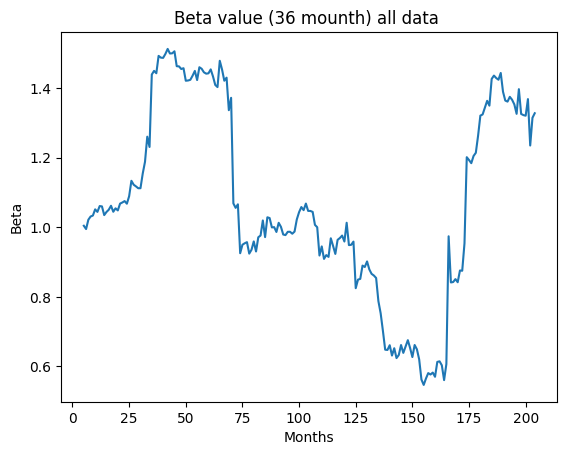

In [32]:
plt.plot(y)
plt.xlabel('Months')
plt.ylabel('Beta')
plt.title('Beta value (36 mounth) all data ')
plt.savefig(f'all_data{COMPANY}.png')

In [33]:
y_test

165    0.606939
166    0.974103
167    0.841483
168    0.842637
169    0.851121
170    0.842051
171    0.875850
172    0.875106
173    0.953912
174    1.201371
175    1.193164
176    1.184191
177    1.204824
178    1.214017
179    1.263135
180    1.320789
181    1.324159
182    1.343358
183    1.363312
184    1.349455
185    1.426222
186    1.435857
187    1.428769
188    1.423958
189    1.443389
190    1.389460
191    1.364066
192    1.361070
193    1.374800
194    1.366442
195    1.353047
196    1.325983
197    1.396829
198    1.325707
199    1.322314
200    1.320562
201    1.368290
202    1.234932
203    1.314584
204    1.327663
Name: target, dtype: float64

In [34]:
def single_plot(y_pred, y_real, title):
    x = np.arange(1, len(y_pred) + 1)
    plt.plot(x,y_real, label='real')
    plt.plot(x,y_pred, label='predicted')
    plt.xlabel('day')
    plt.ylabel('month')
    plt.legend()
    plt.title(title)
    return plt.plot()

In [35]:
def generate_plots(y_pred_train, y_pred_test, y_train, y_test, title_1, title_2, to_png, png_name):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

    ax = axes[0]  # Wybór odpowiedniej osi
    plt.sca(ax)  # Ustawienie bieżącej osi
    single_plot(y_pred_train, y_train, title_1)

    ax = axes[1]  # Wybór odpowiedniej osi
    plt.sca(ax)  # Ustawienie bieżącej osi
    single_plot(y_pred_test, y_test, title_2)

    plt.tight_layout()
    if to_png:
        plt.savefig(f'{png_name}.png')
    plt.show()

## Bulding RBF network model

In [36]:
model = Sequential()
rbflayer = RBFLayer(10,
                    initializer=InitCentersRandom(X_train),
                    betas=2.0,
                    input_shape=(5,))
model.add(rbflayer)
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop())


model.fit(X_train, y_train,
          batch_size=10,
          epochs=200,
          verbose=1)

Epoch 1/200
16/16 [==============================] - 1s 2ms/step - loss: 0.8196
Epoch 2/200
16/16 [==============================] - 0s 2ms/step - loss: 0.6800
Epoch 3/200
16/16 [==============================] - 0s 768us/step - loss: 0.5728
Epoch 4/200
16/16 [==============================] - 0s 1ms/step - loss: 0.4757
Epoch 5/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3869
Epoch 6/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3052
Epoch 7/200
16/16 [==============================] - 0s 1ms/step - loss: 0.2325
Epoch 8/200
16/16 [==============================] - 0s 1ms/step - loss: 0.1710
Epoch 9/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1199
Epoch 10/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0813
Epoch 11/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0524
Epoch 12/200
16/16 [==============================] - 0s 2ms/step - loss: 0.0331
Epoch 13/200
16/16 [===============

2/2 [==============================] - 0s 0s/step


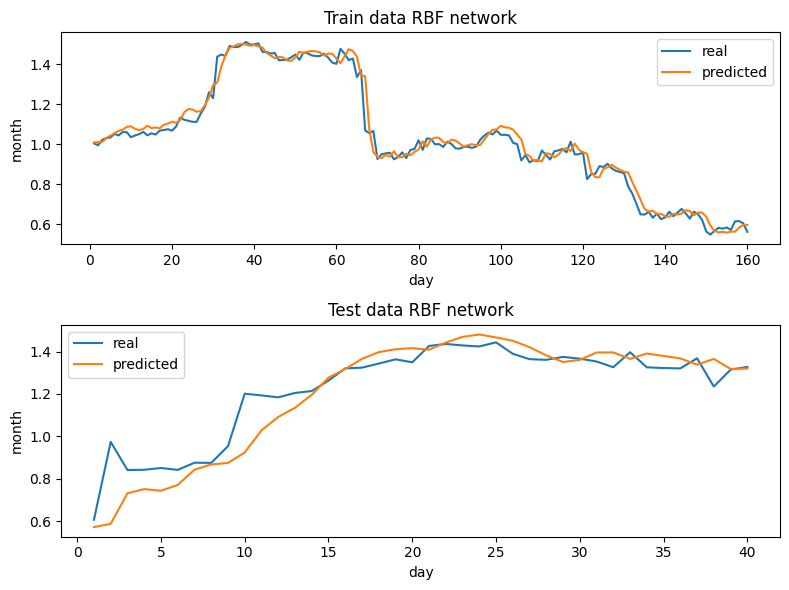

In [37]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data RBF network', 'Test data RBF network', True, f'RBF_{COMPANY}')

In [38]:
import matplotlib.pyplot as plt

def score_table(y_train, y_pred_train, y_test, y_pred_test, title):
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    # Tworzenie tabeli
    data = {'data': ['train', 'test'],
            'MSE': [round(mse_train, 3), round(mse_test, 3)],
            'MAE': [round(mae_train, 3), round(mae_test, 3)],
            'R^2': [round(r2_train, 3), round(r2_test, 3)]
            }

    df = pd.DataFrame(data)

    # Tworzenie wykresu tabeli
    fig, ax = plt.subplots()  # Ustalenie rozmiaru wykresu
    ax.axis('off')  # Wyłączenie osi

    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    # Zapisywanie tabeli jako obraz PNG
    plt.savefig(f'tabela{title}.png', bbox_inches='tight', pad_inches=0.5)
    plt.show()

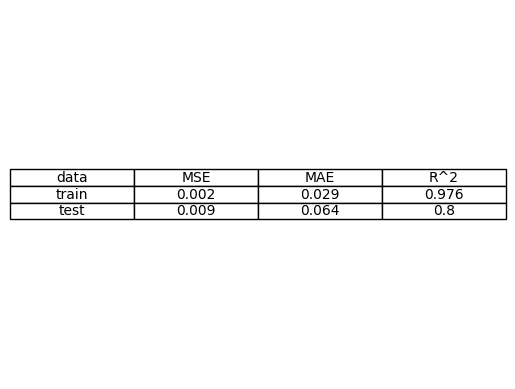

In [39]:
score_table(y_train, y_pred_train, y_test, y_pred_test, f'RBF_{COMPANY}')

## Bulding XGBRegressor model

In [47]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

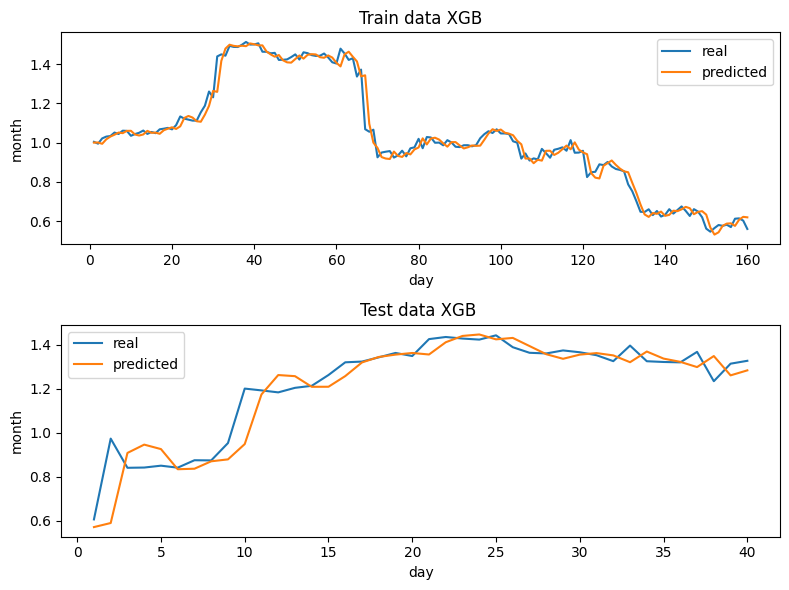

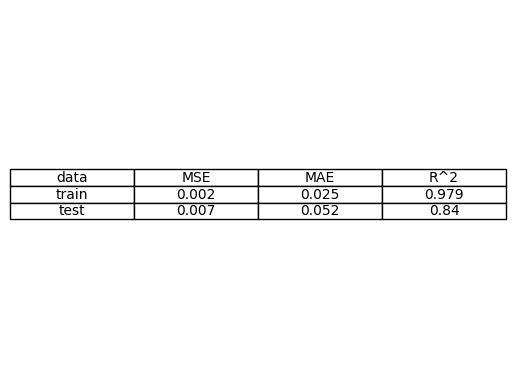

In [48]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data XGB', 'Test data XGB ', True, f'XGB_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'XGB_table_{COMPANY}')

## Bulding LSTM network

In [42]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 5, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 5, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dense_2 (Dense)             (None, 1)                

In [43]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size= 1, epochs=20)

Epoch 1/20
160/160 [==============================] - 6s 5ms/step - loss: 0.0655
Epoch 2/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0181
Epoch 3/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0183
Epoch 4/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0147
Epoch 5/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0151
Epoch 6/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0135
Epoch 7/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0152
Epoch 8/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0125
Epoch 9/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0117
Epoch 10/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0095
Epoch 11/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0086
Epoch 12/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0105
Epoch 13/20
160/160 [====

2/2 [==============================] - 1s 0s/step


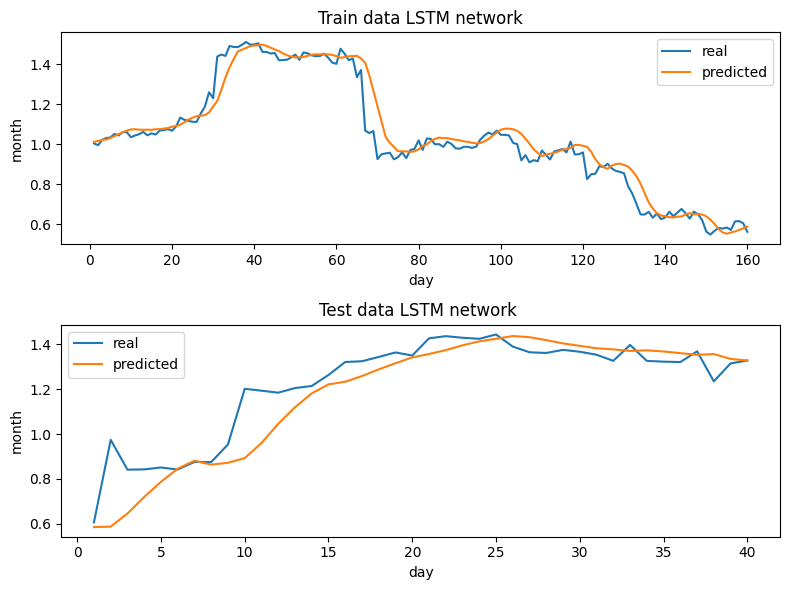

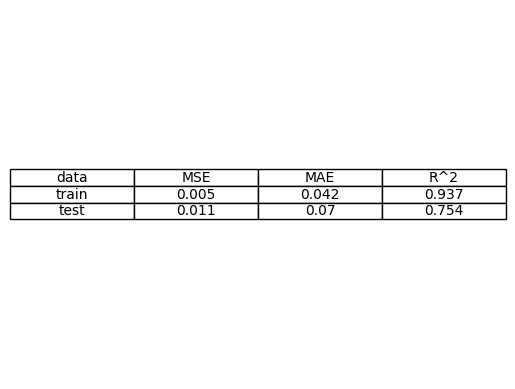

In [44]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data LSTM network', 'Test data LSTM network ', True, f'LSTM_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'LSTM_table_{COMPANY}')

## Bulding Linear regression model

In [45]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

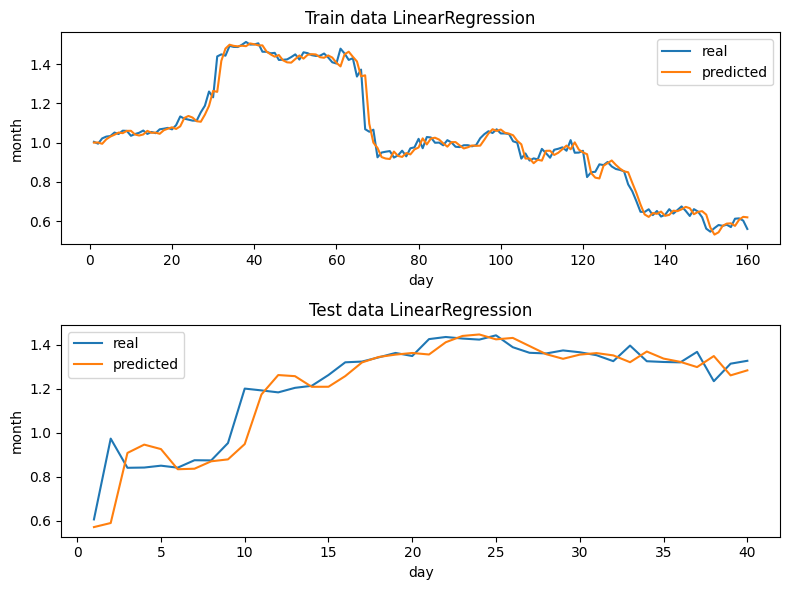

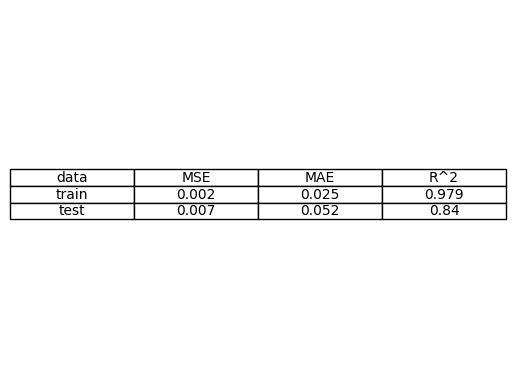

In [46]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data LinearRegression', 'Test data LinearRegression', True, f'LinearRegression_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'LinearRegression_{COMPANY}')